In [1]:
# Standard library imports
import os
import random
import gc
import copy

# Third-party library imports
import numpy as np
import pandas as pd

# PyTorch and related libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

# einops library for tensor operations
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
# Custom TINTO library imports
from TINTOlib.tinto import TINTO
from TINTOlib.supertml import SuperTML
from TINTOlib.igtd import IGTD
from TINTOlib.refined import REFINED
from TINTOlib.barGraph import BarGraph
from TINTOlib.distanceMatrix import DistanceMatrix
from TINTOlib.combination import Combination
from TINTOlib.featureWrap import FeatureWrap
from TINTOlib.bie import BIE

/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

In [3]:
import torch

# Get CUDA version
cuda_version = torch.version.cuda
print(f"CUDA Version: {cuda_version}")

# Get cuDNN version
cudnn_version = torch.backends.cudnn.version()
print(f"cuDNN Version: {cudnn_version}")

# Get PyTorch version
pytorch_version = torch.__version__
print(f"PyTorch Version: {pytorch_version}")

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. PyTorch can use GPU.")
    
    # Get the name of the current GPU
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")
    
    # Create a random tensor and move it to GPU to verify
    x = torch.rand(5, 3)
    print(f"Is this tensor on GPU? {x.cuda().is_cuda}")
else:
    print("CUDA is not available. PyTorch will use CPU.")

# Additional check: is CUDA initialized?
print(f"Is CUDA initialized? {torch.cuda.is_initialized()}")

# Number of available GPUs
print(f"Number of available GPUs: {torch.cuda.device_count()}")

# Current device index
print(f"Current device index: {torch.cuda.current_device()}")


CUDA Version: 12.1
cuDNN Version: 90100
PyTorch Version: 2.5.1+cu121
CUDA is available. PyTorch can use GPU.
Current GPU: NVIDIA A100-PCIE-40GB MIG 7g.40gb
Is this tensor on GPU? True
Is CUDA initialized? True
Number of available GPUs: 1
Current device index: 0


## DATASET

In [4]:
SEED = 64
# SET RANDOM SEED FOR REPRODUCIBILITY
torch.manual_seed(SEED)
random.seed(0)
np.random.seed(0)

In [5]:
# Create variable to store dataset name
dataset_name = 'boston'
results_path = f'logs/Regression/{dataset_name}/CNN_Regression'

In [6]:
df = pd.read_csv(f"./Dataset/Regression/{dataset_name}.csv")

In [7]:
df.shape

(506, 14)

In [8]:
# Drop the second-to-last column if MIMO
# df = df.drop(df.columns[-2], axis=1)

In [9]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


## LOAD AND PREPROCESS

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import os
import cv2

# Function to load and preprocess data
def load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=32):
    
    X_train, X_val = train_test_split(df, test_size=0.20, random_state=SEED)
    X_val, X_test = train_test_split(X_val, test_size=0.50, random_state=SEED)
    X_train = X_train.reset_index(drop=True)
    X_val = X_val.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    
    ### X_train
    # Generate the images if the folder does not exist
    if not os.path.exists(f'{images_folder}/train'):
        #Generate thet images
        image_model.generateImages_fit(X_train, f'{images_folder}/train')
    else:
        print("The images are already generated")

    img_paths = os.path.join(f'{images_folder}/train',problem_type+".csv")

    print(img_paths)
    
    imgs = pd.read_csv(img_paths)
    
    # Update image paths
    imgs["images"] = images_folder + "/train/" + imgs["images"]

    # Combine datasets
    combined_dataset = pd.concat([imgs, X_train], axis=1)

    # Split data
    X_train = combined_dataset.drop(df.columns[-1], axis=1).drop("values", axis=1)
    y_train = combined_dataset["values"]
        
    ### X_val
    # Generate the images if the folder does not exist
    if not os.path.exists(f'{images_folder}/val'):
        #Generate thet images
        image_model.generateImages_pred(X_val, f'{images_folder}/val')
    else:
        print("The images are already generated")

    img_paths = os.path.join(f'{images_folder}/val',problem_type+".csv")

    print(img_paths)
    
    imgs = pd.read_csv(img_paths)

    # Update image paths
    imgs["images"] = images_folder + "/val/" + imgs["images"]

    # Combine datasets
    combined_dataset = pd.concat([imgs, X_val], axis=1)

    # Split data
    X_val = combined_dataset.drop(df.columns[-1], axis=1).drop("values", axis=1)
    y_val = combined_dataset["values"]
    
    ### X_test
    # Generate the images if the folder does not exist
    if not os.path.exists(f'{images_folder}/test'):
        #Generate thet images
        image_model.generateImages_fit(X_test, f'{images_folder}/test')
    else:
        print("The images are already generated")

    img_paths = os.path.join(f'{images_folder}/test',problem_type+".csv")

    print(img_paths)
    
    imgs = pd.read_csv(img_paths)

    # Update image paths
    imgs["images"] = images_folder + "/test/" + imgs["images"]

    # Combine datasets
    combined_dataset = pd.concat([imgs, X_test], axis=1)

    # Split data
    X_test = combined_dataset.drop(df.columns[-1], axis=1).drop("values", axis=1)
    y_test = combined_dataset["values"]
    
    # Numerical data
    X_train_num = X_train.drop("images", axis=1)
    X_val_num = X_val.drop("images", axis=1)
    X_test_num = X_test.drop("images", axis=1)

    # Image data
    X_train_img = np.array([cv2.imread(img) for img in X_train["images"]])
    X_val_img = np.array([cv2.imread(img) for img in X_val["images"]])
    X_test_img = np.array([cv2.imread(img) for img in X_test["images"]])

    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Scale numerical data
    X_train_num = pd.DataFrame(scaler.fit_transform(X_train_num), columns=X_train_num.columns)
    X_val_num = pd.DataFrame(scaler.transform(X_val_num), columns=X_val_num.columns)
    X_test_num = pd.DataFrame(scaler.transform(X_test_num), columns=X_test_num.columns)

    attributes = len(X_train_num.columns)
    height, width, channels = X_train_img[0].shape
    imgs_shape = (channels, height, width)

    print("Images shape: ", imgs_shape)
    print("Attributes: ", attributes)
    # Convert data to PyTorch tensors
    X_train_num_tensor = torch.as_tensor(X_train_num.values, dtype=torch.float32)
    X_val_num_tensor = torch.as_tensor(X_val_num.values, dtype=torch.float32)
    X_test_num_tensor = torch.as_tensor(X_test_num.values, dtype=torch.float32)
    X_train_img_tensor = torch.as_tensor(X_train_img, dtype=torch.float32).permute(0, 3, 1, 2)
    X_val_img_tensor = torch.as_tensor(X_val_img, dtype=torch.float32).permute(0, 3, 1, 2)
    X_test_img_tensor = torch.as_tensor(X_test_img, dtype=torch.float32).permute(0, 3, 1, 2)
    y_train_tensor = torch.as_tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
    y_val_tensor = torch.as_tensor(y_val.values, dtype=torch.float32).reshape(-1, 1)
    y_test_tensor = torch.as_tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

    # Create DataLoaders
    train_dataset = TensorDataset(X_train_img_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_img_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_img_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader, attributes, imgs_shape 

## MODEL ARCHITECTURES

In [11]:
class Model1(nn.Module):
    def __init__(self, imgs_shape):
        super(Model1, self).__init__()
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=2),
            nn.ReLU(),
            nn.Flatten()
        )

        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(imgs_shape)

        # Final MLP layers
        self.final_mlp = nn.Sequential(
            nn.Linear(self.flat_size, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )
        
    def _get_flat_size(self, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_input = torch.zeros(4, *imgs_shape)
        x = self.cnn_branch(dummy_input)
        return x.size(1)

    def forward(self, x):
        cnn_output = self.cnn_branch(x)
        final_output = self.final_mlp(cnn_output)
        return final_output

In [12]:
class Model2(nn.Module):
    def __init__(self, imgs_shape):
        super(Model2, self).__init__()
        
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        
        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(imgs_shape)

        # Dense layers
        self.final_mlp = nn.Sequential(
            nn.Linear(self.flat_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
    def _get_flat_size(self, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_input = torch.zeros(4, *imgs_shape)
        x = self.cnn_branch(dummy_input)
        return x.size(1)

    def forward(self, x):
        # CNN branch
        cnn_output = self.cnn_branch(x)
        
        final_output = self.final_mlp(cnn_output)
        return final_output

In [13]:
class Model3(nn.Module):
    def __init__(self, imgs_shape):
        super(Model3, self).__init__()
        # The formula to calculate the padding is:
        # padding = (kernel_size - 1) // 2


        dropout = 0.1

        # CNN branch 1
        self.branch_1 = nn.Sequential(
            nn.Conv2d(imgs_shape[0], out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout),
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout)
        )

        # CNN branch 2
        self.branch_2 = nn.Sequential(
            nn.Conv2d(imgs_shape[0], out_channels=16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout),
            
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout),
            
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout),

            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout)
        )

        self.flatten = nn.Flatten()

        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(imgs_shape)

        # Dense layers
        self.final_mlp = nn.Sequential(
            nn.Linear(self.flat_size,  512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1),
        )

    def _get_flat_size(self, cnn_input_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_input = torch.zeros(4, *cnn_input_shape)
        branch_1_out = self.branch_1(dummy_input)  # branch_1
        branch_2_out = self.branch_2(dummy_input)  # branch_2
        concat_out = torch.cat((branch_1_out, branch_2_out), dim=1)
        flattened_out = self.flatten(concat_out)
        return flattened_out.size(1)

        
    def forward(self, x):
        branch_1_out = self.branch_1(x)
        branch_2_out = self.branch_2(x)
        merged_cnn = torch.cat((branch_1_out, branch_2_out), dim=1)
        flattened = self.flatten(merged_cnn)
        final_output = self.final_mlp(flattened)
        return final_output

## COMPILE AND FIT

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.optim.lr_scheduler import OneCycleLR
import matplotlib.pyplot as plt
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import os

def compile_and_fit(model, train_loader, val_loader, test_loader, dataset_name, model_name, batch_size=32, epochs=100, min_lr=1e-3, max_lr=1, device='cuda', weight_decay=1e-2):
    model = model.to(device)
    loss_fn = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=min_lr, weight_decay=weight_decay)
    
    total_steps = epochs * len(train_loader)
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, div_factor=max_lr/min_lr, total_steps=total_steps, pct_start=0.3, final_div_factor=1)
    
    best_val_loss = float('inf')
    early_stopping_counter = 0
    early_stopping_patience = 20
    best_model = None
    best_epoch = 0
    warm_up_epochs = epochs*0.3

    history = {'train_loss': [], 'val_loss': [], 'train_mse': [], 'val_mse': [], 'train_rmse': [], 'val_rmse': [], 'learning_rate': [], 'epoch_time': []}

    start_time = time.time()
    
    for epoch in range(epochs):
        epoch_start_time = time.time()

        model.train()
        train_loss = 0.0
        train_predictions = []
        train_targets = []
        for img_data, targets in train_loader:
            img_data, targets = img_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            outputs = model(img_data)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item()
            train_predictions.extend(outputs.cpu().detach().numpy())
            train_targets.extend(targets.cpu().numpy())

        model.eval()
        val_loss = 0.0
        val_predictions = []
        val_targets = []
        with torch.no_grad():
            for img_data, targets in val_loader:
                img_data, targets = img_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
                outputs = model(img_data)
                loss = loss_fn(outputs, targets)
                
                val_loss += loss.item()
                val_predictions.extend(outputs.cpu().numpy())
                val_targets.extend(targets.cpu().numpy())

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        # Get the current learning rate
        current_lr = scheduler.get_last_lr()
        
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())
            best_epoch = epoch + 1
            #early_stopping_counter = 0
        #else:
            #if epoch > warm_up_epochs:
                #early_stopping_counter += 1
                #if early_stopping_counter >= early_stopping_patience:
                    #print(f"Early stopping triggered at epoch {epoch+1}")
                    #break

        train_mse = mean_squared_error(train_targets, train_predictions)
        train_rmse = np.sqrt(train_mse)
        val_mse = mean_squared_error(val_targets, val_predictions)
        val_rmse = np.sqrt(val_mse)
        train_r2 = r2_score(train_targets, train_predictions)
        val_r2 = r2_score(val_targets, val_predictions)

        epoch_time = time.time() - epoch_start_time

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_mse'].append(train_mse)
        history['val_mse'].append(val_mse)
        history['train_rmse'].append(train_rmse)
        history['val_rmse'].append(val_rmse)
        history['learning_rate'].append(current_lr)
        history['epoch_time'].append(epoch_time)

    total_time = time.time() - start_time
    model.load_state_dict(best_model)

    # Calculate and save metrics
    train_metrics = calculate_metrics(model, train_loader, device)
    val_metrics = calculate_metrics(model, val_loader, device)
    test_metrics = calculate_metrics(model, test_loader, device)

    metrics = {
        'train_loss': train_metrics['loss'],
        'train_mse': train_metrics['mse'],
        'train_mae': train_metrics['mae'],
        'train_rmse': train_metrics['rmse'],
        'train_r2': train_metrics['r2'],
        'val_loss': val_metrics['loss'],
        'val_mse': val_metrics['mse'],
        'val_mae': val_metrics['mae'],
        'val_rmse': val_metrics['rmse'],
        'val_r2': val_metrics['r2'],
        'test_loss': test_metrics['loss'],
        'test_mse': test_metrics['mse'],
        'test_mae': test_metrics['mae'],
        'test_rmse': test_metrics['rmse'],
        'test_r2': test_metrics['r2'],
        'min_lr': min_lr,
        'max_lr': max_lr,
        'total_time': total_time,
        'average_epoch_time': sum(history['epoch_time']) / len(history['epoch_time'])
    }
    
    print(f"\nTraining completed in {total_time:.2f} seconds")
    print(f"Best model found at epoch {best_epoch}/{epochs}")
    print(f"Best Train Loss: {history['train_loss'][best_epoch-1]:.4f}, Best Val Loss: {history['val_loss'][best_epoch-1]:.4f}")
    print(f"Best Train MSE: {history['train_mse'][best_epoch-1]:.4f}, Best Val MSE: {history['val_mse'][best_epoch-1]:.4f}")
    print(f"Best Train RMSE: {history['train_rmse'][best_epoch-1]:.4f}, Best Val RMSE: {history['val_rmse'][best_epoch-1]:.4f}")

    # Save figures for this fold
    os.makedirs(f"models/Regression/{dataset_name}/CNN/{model_name}", exist_ok=True)
    plot_metric(history['train_loss'], history['val_loss'], 'Loss', dataset_name, model_name)
    plot_metric(history['train_mse'], history['val_mse'], 'MSE', dataset_name, model_name)
    plot_metric(history['train_rmse'], history['val_rmse'], 'RMSE', dataset_name, model_name)
    plot_learning_rate(history['learning_rate'], dataset_name, model_name)

    # Save metrics to a file
    os.makedirs(f'logs/Regression/{dataset_name}/CNN/{model_name}', exist_ok=True)
    with open(f'logs/Regression/{dataset_name}/CNN/{model_name}/metrics.txt', 'w') as f:
        for key, value in metrics.items():
            f.write(f'{key}: {value}\n')

    # Save best model
    model_save_path = f"models/Regression/{dataset_name}/CNN/{model_name}/best_model.pth"
    os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
    torch.save(best_model, model_save_path)
    print(f"Best model saved to {model_save_path}")
            
    del model
    torch.cuda.empty_cache()
    gc.collect()

    return metrics

def calculate_metrics(model, data_loader, device):
    model.eval()
    loss_fn = nn.MSELoss()
    total_loss = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for img_data, targets in data_loader:
            img_data, targets = img_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            outputs = model(img_data)
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

    all_targets = np.array(all_targets)
    all_predictions = np.array(all_predictions)

    mse = mean_squared_error(all_targets, all_predictions)
    mae = mean_absolute_error(all_targets, all_predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(all_targets, all_predictions)

    return {
        'loss': total_loss / len(data_loader),
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'r2': r2
    }    

def plot_metric(train_metric, val_metric, metric_name, dataset_name, model_name):
    plt.figure()
    plt.plot(train_metric, label=f'Train {metric_name}')
    plt.plot(val_metric, label=f'Validation {metric_name}')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()
    plt.title(f'{metric_name} vs. Epoch')
    plt.savefig(f"models/Regression/{dataset_name}/CNN/{model_name}/{metric_name.lower()}_plot.png")
    plt.close()

def plot_learning_rate(learning_rates, dataset_name, model_name):
    plt.figure()
    plt.plot(learning_rates)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate vs. Epoch')
    plt.savefig(f"models/Regression/{dataset_name}/CNN/{model_name}/learning_rate_plot.png")
    plt.close()

In [15]:
def safe_compile_and_fit(model, train_loader, val_loader, test_loader, dataset_name, model_name, batch_size=64, epochs=100, min_lr=1e-3, max_lr=1 , device='cuda', weight_decay=1e-2):
    try:
        if model is None:
            print(f"Model {model_name} is None")
            return None
        else:
            # Compile and fit the model
            metrics = compile_and_fit(model, train_loader, val_loader, test_loader, dataset_name, model_name, epochs=epochs, min_lr=min_lr, max_lr=max_lr, device=device, weight_decay=weight_decay)
            return metrics
    except Exception as e:
        print(f"Failed to compile and fit {model_name}: {str(e)}")
        return None
    finally:
        # Clear CUDA cache and force garbage collection
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()

In [16]:
import traceback

def try_create_model(model_class, imgs_shape):
    try:
        model = model_class(imgs_shape)
        
        # Test the model with a sample input
        sample_input = torch.randn(4, *imgs_shape)
        output = model(sample_input)
        
        print(f"Successfully created and tested {model_class.__name__}")
        
        return model
    except Exception as e:
        print(f"Error creating or testing {model_class.__name__}: {str(e)}")
        traceback.print_exc()
        return None

In [17]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch_lr_finder import LRFinder

def run_lr_finder(model_class, attributes, imgs_shape, dataset_name, name, train_loader, val_loader, num_iter):

    # Define the path where the plot will be saved
    save_dir = os.path.join(f"logs/Regression/{dataset_name}/CNN/{name}")
    save_path = os.path.join(save_dir, 'lr_finder_plot.png')

    # Check if the file already exists
    if not os.path.exists(save_path):
        # Create and train Model
        model = try_create_model(model_class, imgs_shape)
        
        if model is None:
            return None
        
        # Move model to device
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)
        
        optimizer = optim.AdamW(model.parameters(), lr=1e-7, weight_decay=0.0001)
        criterion = nn.MSELoss()
        
        lr_finder = LRFinder(model, optimizer, criterion, device=device)
        lr_finder.range_test(train_loader, val_loader=val_loader, end_lr=1, num_iter=num_iter, step_mode="exp")
        
        axis, lr = lr_finder.plot()
        
        # Create the directory if it doesn't exist
        os.makedirs(save_dir, exist_ok=True)
        
        # Get the figure from the axis and save it
        fig = axis.figure
        fig.savefig(save_path)
        print(f"Plot saved to: {save_path}")
        
        # Close the figure to ensure it's saved properly
        plt.close(fig)
        
        lr_finder.reset()
        print(f"Suggested learning rate: {lr}")
        
        return lr
    else:
        print(f"LR finder plot already exists at {save_path}. Skipping LR finder process.")
        # Load and display the existing image
        img = plt.imread(save_path)
        plt.figure(figsize=(10, 6))
        plt.imshow(img)
        plt.axis('off')  # Turn off axis numbers and ticks
        plt.title("Learning Rate Finder Plot")
        plt.show()
        
        return None  # Or you could return a default learning rate here

# Usage example:
# lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, name, train_loader, val_loader)

/opt/conda/lib/python3.10/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [18]:
def zoom_and_save_images_pixel_replication(input_folder, output_folder, zoom_factor):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            with Image.open(input_path) as img:
                # Calculate new size
                new_size = tuple(int(dim * zoom_factor) for dim in img.size)
                
                # Resize image using nearest neighbor interpolation
                resized_img = img.resize(new_size, Image.NEAREST)
                
                # Save resized image
                resized_img.save(output_path)

## EXPERIMENTS

In [19]:
#Select the model and the parameters
problem_type = "regression"
image_model = TINTO(problem= problem_type, blur=True, random_seed=SEED)
#image_model = REFINED(problem= problem_type,hcIterations=5)
#image_model = IGTD(problem= problem_type)
#image_model = BarGraph(problem= problem_type)
#image_model = DistanceMatrix(problem= problem_type)
#image_model = Combination(problem= problem_type)
#image_model = SuperTML(problem= problem_type)

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_TINTO"

In [20]:
def calculate_iterations_per_epoch(dataset_size, batch_size):
    iterations = dataset_size // batch_size
    if dataset_size % batch_size != 0:
        iterations += 1
    return iterations

In [21]:
batch_size = 32

In [22]:
num_epochs = calculate_iterations_per_epoch(df.shape[0], batch_size)
# For the Boston dataset, the number of samples is too small for a range test, so the number of epochs is tripled.
num_epochs = num_epochs*3

In [23]:
num_epochs

48

### EXPERIMENT 1: TINTO

In [26]:
#Select the model and the parameters
problem_type = "regression"
image_model = TINTO(problem= problem_type, blur=True, random_seed=SEED)
name = f"TINTO_blur"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [27]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

./HyNNImages/Regression/boston/images_boston_TINTO_blur/train/regression.csv
./HyNNImages/Regression/boston/images_boston_TINTO_blur/val/regression.csv
./HyNNImages/Regression/boston/images_boston_TINTO_blur/test/regression.csv
Images shape:  (3, 20, 20)
Attributes:  13


LR finder plot already exists at logs/Regression/boston/CNN/TINTO_blur_Model1/lr_finder_plot.png. Skipping LR finder process.


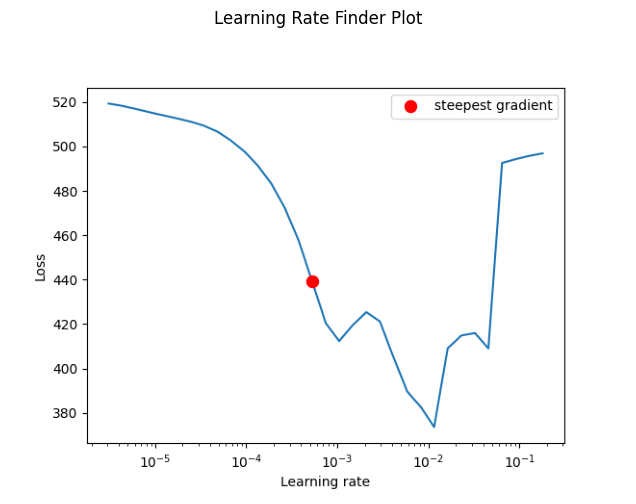

In [28]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [29]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=2e-4, max_lr=3e-3)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 3.86 seconds
Best model found at epoch 99/100
Best Train Loss: 17.1213, Best Val Loss: 14.5113
Best Train MSE: 17.4129, Best Val MSE: 15.5270
Best Train RMSE: 4.1729, Best Val RMSE: 3.9404
Best model saved to models/Regression/boston/CNN/TINTO_blur_Model1/best_model.pth


LR finder plot already exists at logs/Regression/boston/CNN/TINTO_blur_Model2/lr_finder_plot.png. Skipping LR finder process.


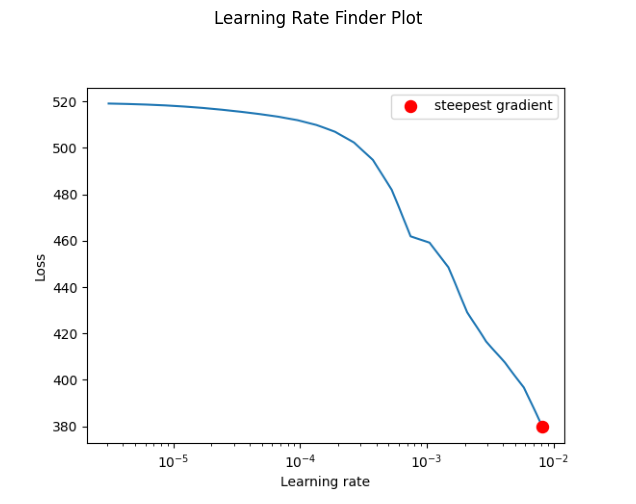

In [30]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [31]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-4, max_lr=1e-3)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 4.19 seconds
Best model found at epoch 66/100
Best Train Loss: 13.2121, Best Val Loss: 12.2103
Best Train MSE: 13.2482, Best Val MSE: 12.5949
Best Train RMSE: 3.6398, Best Val RMSE: 3.5489
Best model saved to models/Regression/boston/CNN/TINTO_blur_Model2/best_model.pth


LR finder plot already exists at logs/Regression/boston/CNN/TINTO_blur_Model3/lr_finder_plot.png. Skipping LR finder process.


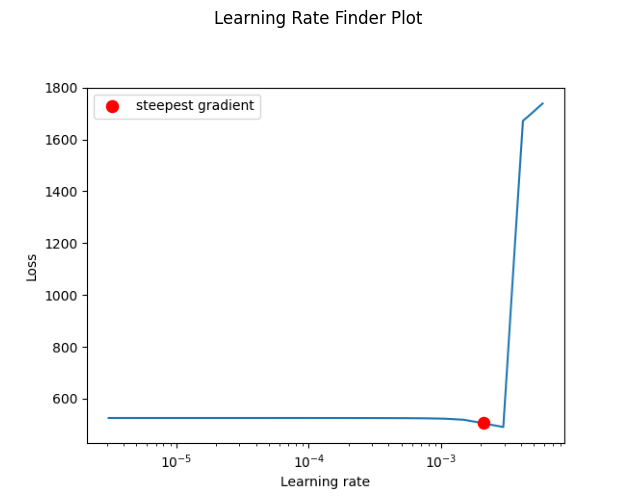

In [32]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [33]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=5e-5, max_lr=1e-3)  # Train and evaluate Model3

Successfully created and tested Model3

Training completed in 9.48 seconds
Best model found at epoch 75/100
Best Train Loss: 25.8297, Best Val Loss: 13.9178
Best Train MSE: 25.7527, Best Val MSE: 14.4740
Best Train RMSE: 5.0747, Best Val RMSE: 3.8045
Best model saved to models/Regression/boston/CNN/TINTO_blur_Model3/best_model.pth


In [34]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 17.31823759812575, 'train_mse': 17.357139587402344, 'train_mae': 2.8730921745300293, 'train_rmse': 4.166190056562751, 'train_r2': 0.7936972975730896, 'val_loss': 14.511321067810059, 'val_mse': 15.526995658874512, 'val_mae': 2.82088565826416, 'val_rmse': 3.940430897614436, 'val_r2': 0.7435499429702759, 'test_loss': 113.67303848266602, 'test_mse': 113.48001861572266, 'test_mae': 7.362895488739014, 'test_rmse': 10.652700062224724, 'test_r2': -0.06892967224121094, 'min_lr': 0.0002, 'max_lr': 0.003, 'total_time': 3.8613502979278564, 'average_epoch_time': 0.03861151218414307}
Model 2 Metrics: {'train_loss': 11.843439652369572, 'train_mse': 11.928462028503418, 'train_mae': 2.2702407836914062, 'train_rmse': 3.453760563285101, 'train_r2': 0.8582212328910828, 'val_loss': 12.21030330657959, 'val_mse': 12.594880104064941, 'val_mae': 2.6848480701446533, 'val_rmse': 3.54892661294439, 'val_r2': 0.7919779419898987, 'test_loss': 128.06002044677734, 'test_mse': 135.998306

In [ ]:
#Select the model and the parameters
problem_type = "regression"
image_model = TINTO(problem= problem_type, blur=True, option="maximum", random_seed=SEED)
name = f"TINTO_blur_maximum"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [ ]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

In [ ]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=7e-5, max_lr=3e-3)  # Train and evaluate Model1

In [ ]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-4, max_lr=3e-3)  # Train and evaluate Model2


In [ ]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=4e-5, max_lr=3e-4)  # Train and evaluate Model3

In [ ]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

In [ ]:
#Select the model and the parameters
problem_type = "regression"
image_model = TINTO(problem= problem_type, random_seed=SEED)
name = f"TINTO"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [ ]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

In [ ]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=8e-5, max_lr=4e-3)  # Train and evaluate Model1

In [ ]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=4e-5, max_lr=1e-3)  # Train and evaluate Model2


In [ ]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=4e-5, max_lr=4e-4)  # Train and evaluate Model3

In [ ]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

### EXPERIMENT 2: IGTD

In [35]:
# Get the shape of the dataframe
num_columns = df.shape[1]

# Calculate number of columns - 1
columns_minus_one = num_columns - 1

# Calculate the square root for image size
import math
image_size = math.ceil(math.sqrt(columns_minus_one))
print(image_size)

4


In [36]:
#Select the model and the parameters
problem_type = "regression"
image_model = IGTD(problem= problem_type, scale=[image_size,image_size], fea_dist_method='Euclidean', image_dist_method='Euclidean', error='abs', max_step=30000, val_step=300, random_seed=SEED)
name = f"IGTD_{image_size}x{image_size}_fEuclidean_iEuclidean_abs"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [37]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

./HyNNImages/Regression/boston/images_boston_IGTD_4x4_fEuclidean_iEuclidean_abs/train/regression.csv
./HyNNImages/Regression/boston/images_boston_IGTD_4x4_fEuclidean_iEuclidean_abs/val/regression.csv
./HyNNImages/Regression/boston/images_boston_IGTD_4x4_fEuclidean_iEuclidean_abs/test/regression.csv
Images shape:  (3, 4, 4)
Attributes:  13


LR finder plot already exists at logs/Regression/boston/CNN/IGTD_4x4_fEuclidean_iEuclidean_abs_Model1/lr_finder_plot.png. Skipping LR finder process.


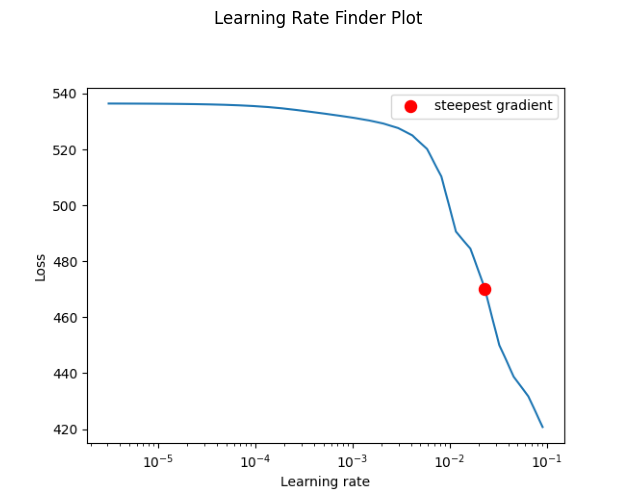

In [38]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [39]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-3, max_lr=1e-1)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 3.28 seconds
Best model found at epoch 9/100
Best Train Loss: 16.8204, Best Val Loss: 18.3854
Best Train MSE: 16.9972, Best Val MSE: 18.9037
Best Train RMSE: 4.1228, Best Val RMSE: 4.3478
Best model saved to models/Regression/boston/CNN/IGTD_4x4_fEuclidean_iEuclidean_abs_Model1/best_model.pth


LR finder plot already exists at logs/Regression/boston/CNN/IGTD_4x4_fEuclidean_iEuclidean_abs_Model2/lr_finder_plot.png. Skipping LR finder process.


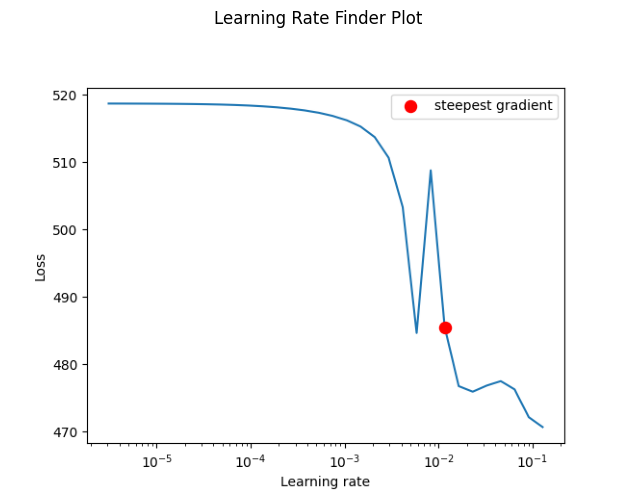

In [40]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [41]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-3, max_lr=1e-1)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 4.05 seconds
Best model found at epoch 12/100
Best Train Loss: 72.5801, Best Val Loss: 27.4595
Best Train MSE: 73.7482, Best Val MSE: 29.1197
Best Train RMSE: 8.5877, Best Val RMSE: 5.3963
Best model saved to models/Regression/boston/CNN/IGTD_4x4_fEuclidean_iEuclidean_abs_Model2/best_model.pth


In [42]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

Error creating or testing Model3: Given input size: (64x1x1). Calculated output size: (64x0x0). Output size is too small


Traceback (most recent call last):
  File "/tmp/ipykernel_10381/495123367.py", line 5, in try_create_model
    model = model_class(imgs_shape)
  File "/tmp/ipykernel_10381/2359567951.py", line 67, in __init__
    self.flat_size = self._get_flat_size(imgs_shape)
  File "/tmp/ipykernel_10381/2359567951.py", line 92, in _get_flat_size
    branch_1_out = self.branch_1(dummy_input)  # branch_1
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3

In [43]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=2e-5, max_lr=4e-4)  # Train and evaluate Model3

Error creating or testing Model3: Given input size: (64x1x1). Calculated output size: (64x0x0). Output size is too small
Model IGTD_4x4_fEuclidean_iEuclidean_abs_Model3 is None


Traceback (most recent call last):
  File "/tmp/ipykernel_10381/495123367.py", line 5, in try_create_model
    model = model_class(imgs_shape)
  File "/tmp/ipykernel_10381/2359567951.py", line 67, in __init__
    self.flat_size = self._get_flat_size(imgs_shape)
  File "/tmp/ipykernel_10381/2359567951.py", line 92, in _get_flat_size
    branch_1_out = self.branch_1(dummy_input)  # branch_1
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3

In [44]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 15.506945023169884, 'train_mse': 15.633334159851074, 'train_mae': 2.7958290576934814, 'train_rmse': 3.95390113177493, 'train_r2': 0.8141859769821167, 'val_loss': 18.385443687438965, 'val_mse': 18.903656005859375, 'val_mae': 3.191195011138916, 'val_rmse': 4.347833484145796, 'val_r2': 0.6877796649932861, 'test_loss': 136.3324737548828, 'test_mse': 132.90614318847656, 'test_mae': 8.196256637573242, 'test_rmse': 11.528492667668075, 'test_r2': -0.2519148588180542, 'min_lr': 0.001, 'max_lr': 0.1, 'total_time': 3.2754063606262207, 'average_epoch_time': 0.032752246856689454}
Model 2 Metrics: {'train_loss': 28.261113166809082, 'train_mse': 28.309804916381836, 'train_mae': 3.795339822769165, 'train_rmse': 5.3206959052723395, 'train_r2': 0.6635165810585022, 'val_loss': 27.459529876708984, 'val_mse': 29.119657516479492, 'val_mae': 3.9885878562927246, 'val_rmse': 5.396263291990069, 'val_r2': 0.5190481543540955, 'test_loss': 86.12884902954102, 'test_mse': 85.963523864

In [ ]:
#Select the model and the parameters
problem_type = "regression"
image_model = IGTD(problem= problem_type, scale=[image_size,image_size], fea_dist_method='Euclidean', image_dist_method='Euclidean', zoom=2, random_seed=SEED)
name = f"IGTD_{image_size*2}x{image_size*2}_fEuclidean_iEuclidean_abs"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [ ]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

In [ ]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=2e-5, max_lr=1e-3)  # Train and evaluate Model1

In [ ]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-3, max_lr=3e-2)  # Train and evaluate Model2


In [ ]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=2e-3, max_lr=6e-2)  # Train and evaluate Model3

In [ ]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

In [ ]:
#Select the model and the parameters
problem_type = "regression"
image_model = IGTD(problem= problem_type, scale=[image_size,image_size], fea_dist_method='Euclidean', image_dist_method='Euclidean', zoom=4, random_seed=SEED)
name = f"IGTD_{image_size*4}x{image_size*4}_fEuclidean_iEuclidean_abs"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [ ]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

In [ ]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-5, max_lr=3e-2)  # Train and evaluate Model1

In [ ]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-5, max_lr=1e-2)  # Train and evaluate Model2


In [ ]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=1e-5, max_lr=1e-3)  # Train and evaluate Model3

In [ ]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

### EXPERIMENT 3: REFINED

In [45]:
#Select the model and the parameters
problem_type = "regression"
image_model = REFINED(problem= problem_type, random_seed=SEED)
name = f"REFINED"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [46]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

./HyNNImages/Regression/boston/images_boston_REFINED/train/regression.csv
./HyNNImages/Regression/boston/images_boston_REFINED/val/regression.csv
./HyNNImages/Regression/boston/images_boston_REFINED/test/regression.csv
Images shape:  (3, 4, 4)
Attributes:  13


LR finder plot already exists at logs/Regression/boston/CNN/REFINED_Model1/lr_finder_plot.png. Skipping LR finder process.


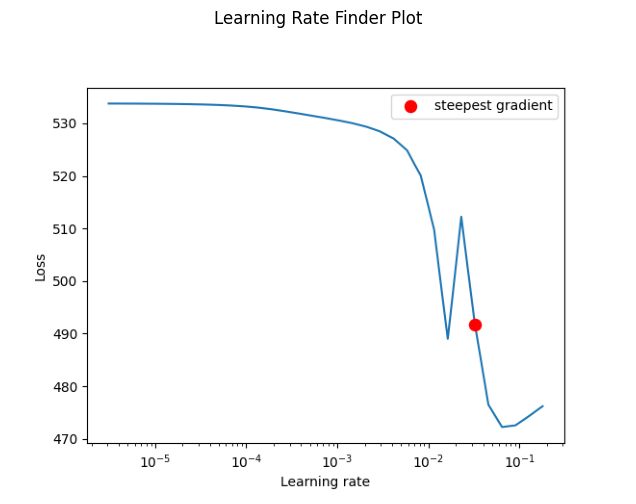

In [47]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [48]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-3, max_lr=5e-2)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 3.40 seconds
Best model found at epoch 45/100
Best Train Loss: 23.0867, Best Val Loss: 18.5324
Best Train MSE: 23.0193, Best Val MSE: 19.8097
Best Train RMSE: 4.7978, Best Val RMSE: 4.4508
Best model saved to models/Regression/boston/CNN/REFINED_Model1/best_model.pth


LR finder plot already exists at logs/Regression/boston/CNN/REFINED_Model2/lr_finder_plot.png. Skipping LR finder process.


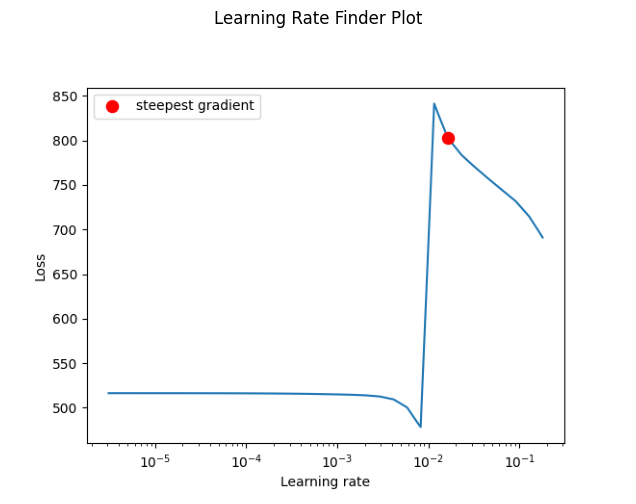

In [49]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [50]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-3, max_lr=7e-3)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 4.04 seconds
Best model found at epoch 99/100
Best Train Loss: 16.8757, Best Val Loss: 23.7278
Best Train MSE: 16.9510, Best Val MSE: 25.8059
Best Train RMSE: 4.1172, Best Val RMSE: 5.0800
Best model saved to models/Regression/boston/CNN/REFINED_Model2/best_model.pth


In [51]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

Error creating or testing Model3: Given input size: (64x1x1). Calculated output size: (64x0x0). Output size is too small


Traceback (most recent call last):
  File "/tmp/ipykernel_10381/495123367.py", line 5, in try_create_model
    model = model_class(imgs_shape)
  File "/tmp/ipykernel_10381/2359567951.py", line 67, in __init__
    self.flat_size = self._get_flat_size(imgs_shape)
  File "/tmp/ipykernel_10381/2359567951.py", line 92, in _get_flat_size
    branch_1_out = self.branch_1(dummy_input)  # branch_1
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3

In [52]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=2e-5, max_lr=6e-4)  # Train and evaluate Model3

Error creating or testing Model3: Given input size: (64x1x1). Calculated output size: (64x0x0). Output size is too small
Model REFINED_Model3 is None


Traceback (most recent call last):
  File "/tmp/ipykernel_10381/495123367.py", line 5, in try_create_model
    model = model_class(imgs_shape)
  File "/tmp/ipykernel_10381/2359567951.py", line 67, in __init__
    self.flat_size = self._get_flat_size(imgs_shape)
  File "/tmp/ipykernel_10381/2359567951.py", line 92, in _get_flat_size
    branch_1_out = self.branch_1(dummy_input)  # branch_1
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3

In [53]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 18.768168412722073, 'train_mse': 19.00916862487793, 'train_mae': 2.990680694580078, 'train_rmse': 4.359950530095259, 'train_r2': 0.7740616798400879, 'val_loss': 18.532437324523926, 'val_mse': 19.80966567993164, 'val_mae': 3.1150338649749756, 'val_rmse': 4.450805059753981, 'val_r2': 0.6728156805038452, 'test_loss': 1734.7755737304688, 'test_mse': 1723.3956298828125, 'test_mae': 39.53911590576172, 'test_rmse': 41.513800475056634, 'test_r2': -15.23359489440918, 'min_lr': 0.001, 'max_lr': 0.05, 'total_time': 3.400038003921509, 'average_epoch_time': 0.03399835348129272}
Model 2 Metrics: {'train_loss': 17.347396777226376, 'train_mse': 17.56863784790039, 'train_mae': 2.988764762878418, 'train_rmse': 4.191495896204646, 'train_r2': 0.7911834716796875, 'val_loss': 23.72777271270752, 'val_mse': 25.805908203125, 'val_mae': 3.875178337097168, 'val_rmse': 5.079951594565149, 'val_r2': 0.5737793445587158, 'test_loss': 61581.845703125, 'test_mse': 61059.04296875, 'test_m

In [ ]:
#Select the model and the parameters
problem_type = "regression"
image_model = REFINED(problem= problem_type, zoom=2, random_seed=SEED)
name = f"REFINED_zoom2"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [ ]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

In [ ]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=2e-5, max_lr=6e-2)  # Train and evaluate Model1

In [ ]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-4, max_lr=3e-3)  # Train and evaluate Model2


In [ ]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=2e-3, max_lr=9e-2)  # Train and evaluate Model3

In [ ]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

In [ ]:
#Select the model and the parameters
problem_type = "regression"
image_model = REFINED(problem= problem_type, zoom=4, random_seed=SEED)
name = f"REFINED_zoom4"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [ ]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

In [ ]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-6, max_lr=1e-1)  # Train and evaluate Model1

In [ ]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=5e-5, max_lr=2e-2)  # Train and evaluate Model2


In [ ]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=3e-5, max_lr=1e-3)  # Train and evaluate Model3

In [ ]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

### EXPERIMENT 4: BAR GRAPH

In [54]:
#Select the model and the parameters
problem_type = "regression"
image_model = BarGraph(problem = problem_type)
name = f"BarGraph"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [55]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

The images are already generated
../HyNNImages/Regression/boston/images_boston_BarGraph/train/regression.csv
../HyNNImages/Regression/boston/images_boston_BarGraph/val/regression.csv
../HyNNImages/Regression/boston/images_boston_BarGraph/test/regression.csv
Images shape:  (3, 13, 13)
Attributes:  13


Successfully created and tested Model1


  0%|          | 0/48 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.94E-03


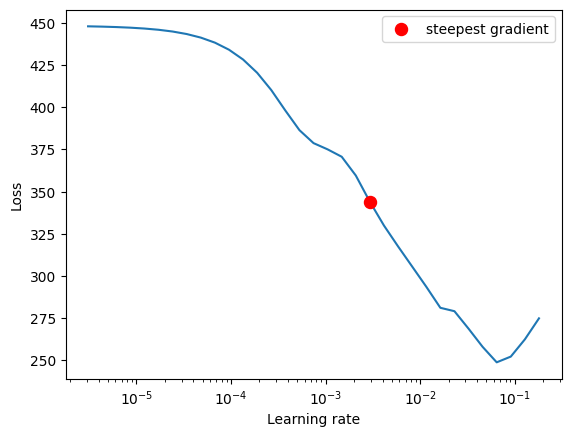

Plot saved to: logs/Regression/boston/CNN/BarGraph_Model1/lr_finder_plot.png
Suggested learning rate: 0.0029382253839710104


In [56]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [57]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-5, max_lr=5e-2)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 3.64 seconds
Best model found at epoch 73/100
Best Train Loss: 9.3408, Best Val Loss: 25.1909
Best Train MSE: 9.2746, Best Val MSE: 27.0556
Best Train RMSE: 3.0454, Best Val RMSE: 5.2015
Best model saved to models/Regression/boston/CNN/BarGraph_Model1/best_model.pth


Successfully created and tested Model2


  0%|          | 0/48 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.75E-04


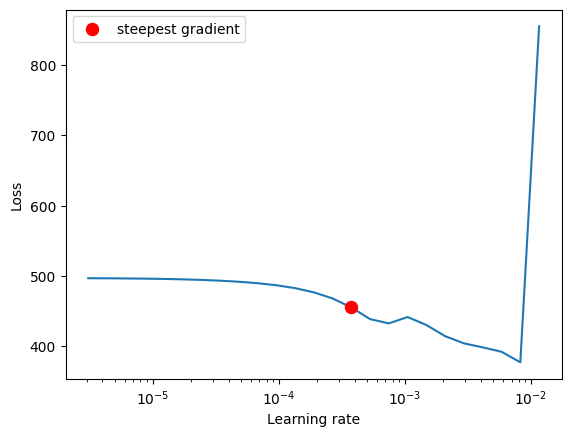

Plot saved to: logs/Regression/boston/CNN/BarGraph_Model2/lr_finder_plot.png
Suggested learning rate: 0.00037537736819256024


In [58]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [59]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-4, max_lr=3e-2)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 4.26 seconds
Best model found at epoch 10/100
Best Train Loss: 22.0513, Best Val Loss: 17.3022
Best Train MSE: 22.3904, Best Val MSE: 18.6743
Best Train RMSE: 4.7319, Best Val RMSE: 4.3214
Best model saved to models/Regression/boston/CNN/BarGraph_Model2/best_model.pth


In [60]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

Error creating or testing Model3: Given input size: (64x1x1). Calculated output size: (64x0x0). Output size is too small


Traceback (most recent call last):
  File "/tmp/ipykernel_10381/495123367.py", line 5, in try_create_model
    model = model_class(imgs_shape)
  File "/tmp/ipykernel_10381/2359567951.py", line 67, in __init__
    self.flat_size = self._get_flat_size(imgs_shape)
  File "/tmp/ipykernel_10381/2359567951.py", line 92, in _get_flat_size
    branch_1_out = self.branch_1(dummy_input)  # branch_1
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3

In [61]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=1e-3, max_lr=6e-2)  # Train and evaluate Model3

Error creating or testing Model3: Given input size: (64x1x1). Calculated output size: (64x0x0). Output size is too small
Model BarGraph_Model3 is None


Traceback (most recent call last):
  File "/tmp/ipykernel_10381/495123367.py", line 5, in try_create_model
    model = model_class(imgs_shape)
  File "/tmp/ipykernel_10381/2359567951.py", line 67, in __init__
    self.flat_size = self._get_flat_size(imgs_shape)
  File "/tmp/ipykernel_10381/2359567951.py", line 92, in _get_flat_size
    branch_1_out = self.branch_1(dummy_input)  # branch_1
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3

In [62]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 9.252553279583271, 'train_mse': 9.198835372924805, 'train_mae': 2.099578857421875, 'train_rmse': 3.0329581884564125, 'train_r2': 0.8906648755073547, 'val_loss': 25.19091796875, 'val_mse': 27.05559730529785, 'val_mae': 3.880783796310425, 'val_rmse': 5.201499524684959, 'val_r2': 0.5531389713287354, 'test_loss': 42.85153579711914, 'test_mse': 45.05485916137695, 'test_mae': 4.783977031707764, 'test_rmse': 6.712291647520759, 'test_r2': 0.5756039619445801, 'min_lr': 1e-05, 'max_lr': 0.05, 'total_time': 3.6449551582336426, 'average_epoch_time': 0.03644757986068726}
Model 2 Metrics: {'train_loss': 20.361766448387733, 'train_mse': 20.501615524291992, 'train_mae': 2.9410364627838135, 'train_rmse': 4.527870970366977, 'train_r2': 0.7563228011131287, 'val_loss': 17.302230834960938, 'val_mse': 18.674318313598633, 'val_mae': 3.360121965408325, 'val_rmse': 4.321379214278543, 'val_r2': 0.6915675401687622, 'test_loss': 56.089338302612305, 'test_mse': 61.02043914794922, 't

In [ ]:
#Select the model and the parameters
problem_type = "regression"
image_model = BarGraph(problem= problem_type, zoom=2)
name = f"BarGraph_zoom2"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [ ]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

In [ ]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-5, max_lr=3e-2)  # Train and evaluate Model1

In [ ]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-5, max_lr=2e-2)  # Train and evaluate Model2


In [ ]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=5e-4, max_lr=3e-3)  # Train and evaluate Model3

In [ ]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

In [ ]:
#Select the model and the parameters
problem_type = "regression"
image_model = BarGraph(problem= problem_type, zoom=4)
name = f"BarGraph_zoom4"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [ ]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

In [ ]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=5e-6, max_lr=6e-2)  # Train and evaluate Model1

In [ ]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-5, max_lr=1e-2)  # Train and evaluate Model2


In [ ]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=2e-4, max_lr=2e-3)  # Train and evaluate Model3

In [ ]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

### EXPERIMENT 5: DISTANCE MATRIX

In [63]:
#Select the model and the parameters
problem_type = "regression"
image_model = DistanceMatrix(problem= problem_type)
name = f"DistanceMatrix"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [64]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

../HyNNImages/Regression/boston/images_boston_DistanceMatrix/train/regression.csv
../HyNNImages/Regression/boston/images_boston_DistanceMatrix/val/regression.csv
../HyNNImages/Regression/boston/images_boston_DistanceMatrix/test/regression.csv
Images shape:  (3, 13, 13)
Attributes:  13


Successfully created and tested Model1


  0%|          | 0/48 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.05E-03


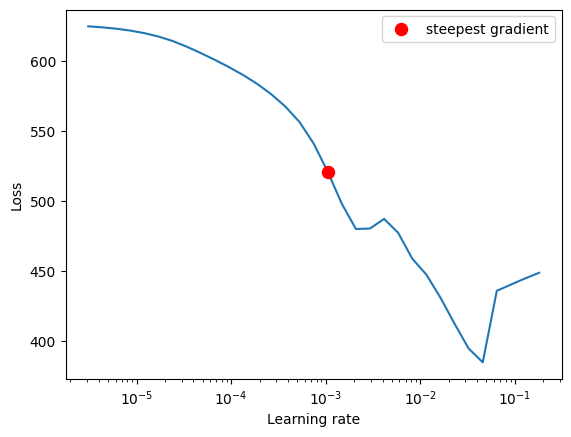

Plot saved to: logs/Regression/boston/CNN/DistanceMatrix_Model1/lr_finder_plot.png
Suggested learning rate: 0.0010502110796366674


In [65]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [66]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-5, max_lr=2e-2)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 3.72 seconds
Best model found at epoch 82/100
Best Train Loss: 54.7823, Best Val Loss: 35.3604
Best Train MSE: 54.5476, Best Val MSE: 38.2177
Best Train RMSE: 7.3856, Best Val RMSE: 6.1820
Best model saved to models/Regression/boston/CNN/DistanceMatrix_Model1/best_model.pth


Successfully created and tested Model2


  0%|          | 0/48 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.30E-02


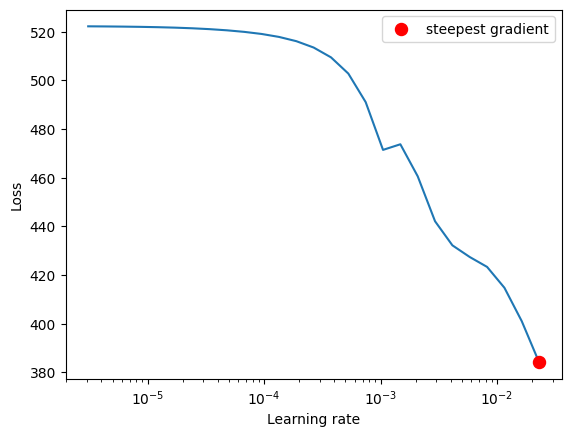

Plot saved to: logs/Regression/boston/CNN/DistanceMatrix_Model2/lr_finder_plot.png
Suggested learning rate: 0.022998638539612096


In [67]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [68]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-5, max_lr=1e-2)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 4.20 seconds
Best model found at epoch 67/100
Best Train Loss: 57.7320, Best Val Loss: 35.0101
Best Train MSE: 57.0520, Best Val MSE: 38.5693
Best Train RMSE: 7.5533, Best Val RMSE: 6.2104
Best model saved to models/Regression/boston/CNN/DistanceMatrix_Model2/best_model.pth


In [69]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

Error creating or testing Model3: Given input size: (64x1x1). Calculated output size: (64x0x0). Output size is too small


Traceback (most recent call last):
  File "/tmp/ipykernel_10381/495123367.py", line 5, in try_create_model
    model = model_class(imgs_shape)
  File "/tmp/ipykernel_10381/2359567951.py", line 67, in __init__
    self.flat_size = self._get_flat_size(imgs_shape)
  File "/tmp/ipykernel_10381/2359567951.py", line 92, in _get_flat_size
    branch_1_out = self.branch_1(dummy_input)  # branch_1
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3

In [70]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=1e-3, max_lr=1e-1)  # Train and evaluate Model3

Error creating or testing Model3: Given input size: (64x1x1). Calculated output size: (64x0x0). Output size is too small
Model DistanceMatrix_Model3 is None


Traceback (most recent call last):
  File "/tmp/ipykernel_10381/495123367.py", line 5, in try_create_model
    model = model_class(imgs_shape)
  File "/tmp/ipykernel_10381/2359567951.py", line 67, in __init__
    self.flat_size = self._get_flat_size(imgs_shape)
  File "/tmp/ipykernel_10381/2359567951.py", line 92, in _get_flat_size
    branch_1_out = self.branch_1(dummy_input)  # branch_1
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3

In [71]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 54.416871584378754, 'train_mse': 54.44843673706055, 'train_mae': 4.885231018066406, 'train_rmse': 7.378918398861757, 'train_r2': 0.3528391122817993, 'val_loss': 35.36038303375244, 'val_mse': 38.21768569946289, 'val_mae': 4.728039741516113, 'val_rmse': 6.182045430071094, 'val_r2': 0.36878150701522827, 'test_loss': 81.40887832641602, 'test_mse': 83.82820892333984, 'test_mae': 6.390668869018555, 'test_rmse': 9.155774621698583, 'test_r2': 0.2103767991065979, 'min_lr': 1e-05, 'max_lr': 0.02, 'total_time': 3.716553211212158, 'average_epoch_time': 0.03716336965560913}
Model 2 Metrics: {'train_loss': 52.9440854879526, 'train_mse': 52.16780471801758, 'train_mae': 4.765355110168457, 'train_rmse': 7.222728343085982, 'train_r2': 0.379946231842041, 'val_loss': 35.010074615478516, 'val_mse': 38.56925964355469, 'val_mae': 4.782074451446533, 'val_rmse': 6.210415416343313, 'val_r2': 0.36297476291656494, 'test_loss': 84.44302368164062, 'test_mse': 87.91996002197266, 'test

In [ ]:
#Select the model and the parameters
problem_type = "regression"
image_model = DistanceMatrix(problem= problem_type, zoom=2)
name = f"DistanceMatrix_zoom2"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [ ]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

In [ ]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=5e-6, max_lr=6e-3)  # Train and evaluate Model1

In [ ]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-5, max_lr=6e-3)  # Train and evaluate Model2


In [ ]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=1e-3, max_lr=3e-3)  # Train and evaluate Model3

In [ ]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

In [ ]:
#Select the model and the parameters
problem_type = "regression"
image_model = DistanceMatrix(problem= problem_type, zoom=4)
name = f"DistanceMatrix_zoom4"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [ ]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

In [ ]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-5, max_lr=3e-2)  # Train and evaluate Model1

In [ ]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-5, max_lr=1e-2)  # Train and evaluate Model2


In [ ]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=8e-4, max_lr=2e-3)  # Train and evaluate Model3

In [ ]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

### EXPERIMENT 6: COMBINATION

In [72]:
#Select the model and the parameters
problem_type = "regression"
image_model = Combination(problem= problem_type)
name = f"Combination"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [73]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

../HyNNImages/Regression/boston/images_boston_Combination/train/regression.csv
../HyNNImages/Regression/boston/images_boston_Combination/val/regression.csv
../HyNNImages/Regression/boston/images_boston_Combination/test/regression.csv
Images shape:  (3, 13, 13)
Attributes:  13


Successfully created and tested Model1


  0%|          | 0/48 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.29E-04


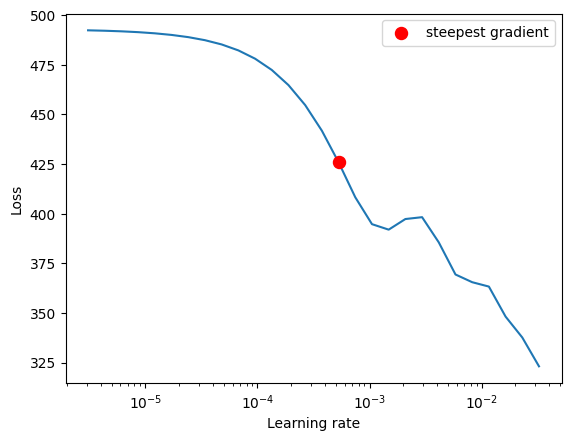

Plot saved to: logs/Regression/boston/CNN/Combination_Model1/lr_finder_plot.png
Suggested learning rate: 0.0005289373746757308


In [74]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [75]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-5, max_lr=8e-2)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 3.64 seconds
Best model found at epoch 8/100
Best Train Loss: 36.0302, Best Val Loss: 24.2119
Best Train MSE: 36.1561, Best Val MSE: 25.8060
Best Train RMSE: 6.0130, Best Val RMSE: 5.0800
Best model saved to models/Regression/boston/CNN/Combination_Model1/best_model.pth


Successfully created and tested Model2


  0%|          | 0/48 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.94E-03


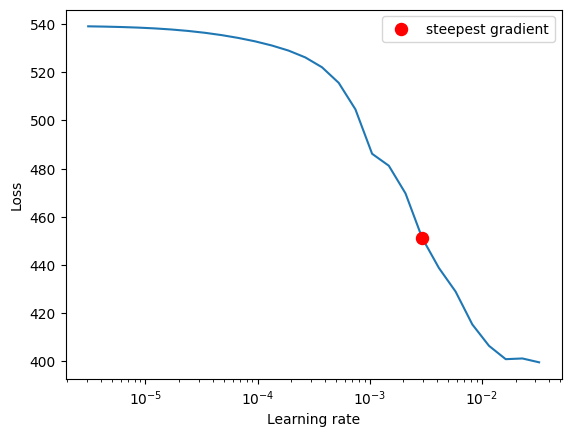

Plot saved to: logs/Regression/boston/CNN/Combination_Model2/lr_finder_plot.png
Suggested learning rate: 0.0029382253839710104


In [76]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [77]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=3e-4, max_lr=1e-2)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 3.74 seconds
Best model found at epoch 56/100
Best Train Loss: 13.2869, Best Val Loss: 18.5038
Best Train MSE: 13.2619, Best Val MSE: 19.4969
Best Train RMSE: 3.6417, Best Val RMSE: 4.4155
Best model saved to models/Regression/boston/CNN/Combination_Model2/best_model.pth


In [78]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

Error creating or testing Model3: Given input size: (64x1x1). Calculated output size: (64x0x0). Output size is too small


Traceback (most recent call last):
  File "/tmp/ipykernel_10381/495123367.py", line 5, in try_create_model
    model = model_class(imgs_shape)
  File "/tmp/ipykernel_10381/2359567951.py", line 67, in __init__
    self.flat_size = self._get_flat_size(imgs_shape)
  File "/tmp/ipykernel_10381/2359567951.py", line 92, in _get_flat_size
    branch_1_out = self.branch_1(dummy_input)  # branch_1
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3

In [79]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=2e-3, max_lr=1e-1)  # Train and evaluate Model3

Error creating or testing Model3: Given input size: (64x1x1). Calculated output size: (64x0x0). Output size is too small
Model Combination_Model3 is None


Traceback (most recent call last):
  File "/tmp/ipykernel_10381/495123367.py", line 5, in try_create_model
    model = model_class(imgs_shape)
  File "/tmp/ipykernel_10381/2359567951.py", line 67, in __init__
    self.flat_size = self._get_flat_size(imgs_shape)
  File "/tmp/ipykernel_10381/2359567951.py", line 92, in _get_flat_size
    branch_1_out = self.branch_1(dummy_input)  # branch_1
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3

In [80]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 25.1197288953341, 'train_mse': 25.42308807373047, 'train_mae': 3.8170413970947266, 'train_rmse': 5.042131302706274, 'train_r2': 0.6978273391723633, 'val_loss': 24.21194553375244, 'val_mse': 25.806005477905273, 'val_mae': 4.105910778045654, 'val_rmse': 5.079961168936754, 'val_r2': 0.5737777352333069, 'test_loss': 25.961374759674072, 'test_mse': 30.112213134765625, 'test_mae': 3.507993698120117, 'test_rmse': 5.487459624887059, 'test_r2': 0.7163567543029785, 'min_lr': 1e-05, 'max_lr': 0.08, 'total_time': 3.638036012649536, 'average_epoch_time': 0.03637857437133789}
Model 2 Metrics: {'train_loss': 11.184784265664907, 'train_mse': 11.302453994750977, 'train_mae': 2.3771417140960693, 'train_rmse': 3.36191225268462, 'train_r2': 0.8656617999076843, 'val_loss': 18.503819942474365, 'val_mse': 19.496868133544922, 'val_mae': 3.51224946975708, 'val_rmse': 4.41552580487816, 'val_r2': 0.677981972694397, 'test_loss': 29.84544563293457, 'test_mse': 32.10663604736328, 'te

In [ ]:
#Select the model and the parameters
problem_type = "regression"
image_model = Combination(problem= problem_type, zoom=2)
name = f"Combination_zoom2"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [ ]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

In [ ]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-5, max_lr=8e-2)  # Train and evaluate Model1

In [ ]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-5, max_lr=4e-3)  # Train and evaluate Model2


In [ ]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=1e-3, max_lr=3e-3)  # Train and evaluate Model3

In [ ]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

In [ ]:
#Select the model and the parameters
problem_type = "regression"
image_model = Combination(problem= problem_type, zoom=4)
name = f"Combination_zoom4"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [ ]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

In [ ]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=5e-6, max_lr=3e-2)  # Train and evaluate Model1

In [ ]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=5e-6, max_lr=3e-3)  # Train and evaluate Model2


In [ ]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=5e-4, max_lr=2e-3)  # Train and evaluate Model3

In [ ]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

### EXPERIMENT 7: SUPERTML

In [24]:
#Select the model and the parameters
problem_type = "regression"
image_model = SuperTML(problem= problem_type, random_seed=SEED)
name = f"SuperTML-EF"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [25]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

../HyNNImages/Regression/boston/images_boston_SuperTML-EF/train/regression.csv
../HyNNImages/Regression/boston/images_boston_SuperTML-EF/val/regression.csv
../HyNNImages/Regression/boston/images_boston_SuperTML-EF/test/regression.csv
Images shape:  (3, 224, 224)
Attributes:  13


Successfully created and tested Model1


  0%|          | 0/48 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.57E-02


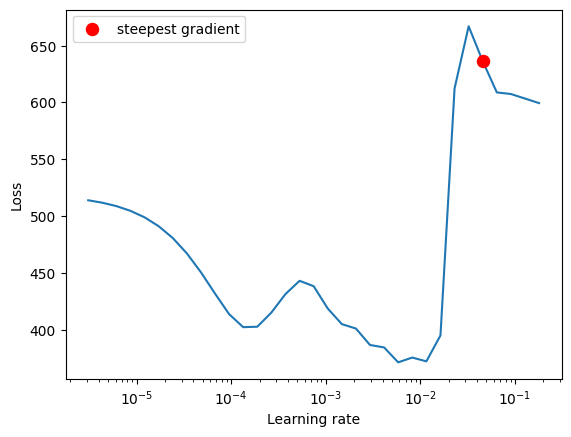

Plot saved to: logs/Regression/boston/CNN/SuperTML-EF_Model1/lr_finder_plot.png
Suggested learning rate: 0.04566405432338165


In [26]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [27]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-5, max_lr=3e-2)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 12.47 seconds
Best model found at epoch 46/100
Best Train Loss: 1.7886, Best Val Loss: 20.0122
Best Train MSE: 1.7995, Best Val MSE: 20.8517
Best Train RMSE: 1.3415, Best Val RMSE: 4.5664
Best model saved to models/Regression/boston/CNN/SuperTML-EF_Model1/best_model.pth


Successfully created and tested Model2


  0%|          | 0/48 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.42E-05


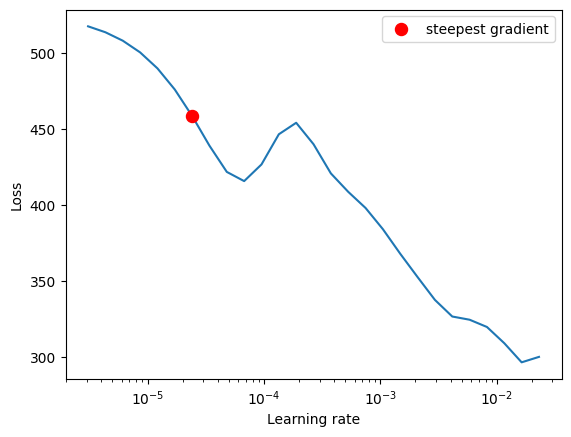

Plot saved to: logs/Regression/boston/CNN/SuperTML-EF_Model2/lr_finder_plot.png
Suggested learning rate: 2.4153425010859467e-05


In [28]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [29]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-5, max_lr=2e-2)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 25.74 seconds
Best model found at epoch 41/100
Best Train Loss: 11.7719, Best Val Loss: 16.5077
Best Train MSE: 11.8183, Best Val MSE: 17.1244
Best Train RMSE: 3.4378, Best Val RMSE: 4.1382
Best model saved to models/Regression/boston/CNN/SuperTML-EF_Model2/best_model.pth


Successfully created and tested Model3


  0%|          | 0/48 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.05E-03


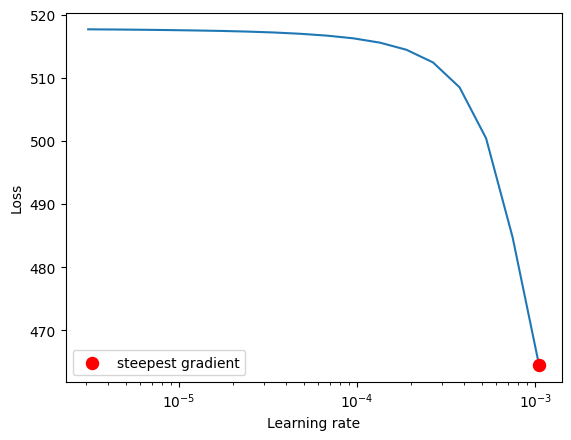

Plot saved to: logs/Regression/boston/CNN/SuperTML-EF_Model3/lr_finder_plot.png
Suggested learning rate: 0.0010502110796366674


In [30]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [31]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=1e-4, max_lr=2e-3)  # Train and evaluate Model3

Successfully created and tested Model3

Training completed in 41.14 seconds
Best model found at epoch 87/100
Best Train Loss: 14.4685, Best Val Loss: 14.9059
Best Train MSE: 14.6354, Best Val MSE: 16.1574
Best Train RMSE: 3.8256, Best Val RMSE: 4.0196
Best model saved to models/Regression/boston/CNN/SuperTML-EF_Model3/best_model.pth


In [32]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 1.2459576863508959, 'train_mse': 1.2490642070770264, 'train_mae': 0.8763427138328552, 'train_rmse': 1.117615411077096, 'train_r2': 0.9851539134979248, 'val_loss': 20.01217555999756, 'val_mse': 20.85167694091797, 'val_mae': 3.543341875076294, 'val_rmse': 4.566363645278152, 'val_r2': 0.6556054353713989, 'test_loss': 14.72148323059082, 'test_mse': 15.098376274108887, 'test_mae': 3.081103563308716, 'test_rmse': 3.8856629130830282, 'test_r2': 0.8577802181243896, 'min_lr': 1e-05, 'max_lr': 0.03, 'total_time': 12.469274759292603, 'average_epoch_time': 0.12468889236450195}
Model 2 Metrics: {'train_loss': 9.872634851015532, 'train_mse': 9.410436630249023, 'train_mae': 2.1583807468414307, 'train_rmse': 3.0676434979066625, 'train_r2': 0.8881498575210571, 'val_loss': 16.507709980010986, 'val_mse': 17.12435531616211, 'val_mae': 3.222038507461548, 'val_rmse': 4.1381584450286715, 'val_r2': 0.7171673774719238, 'test_loss': 14.979915142059326, 'test_mse': 16.708690643310

In [ ]:
#Select the model and the parameters
problem_type = "regression"
image_model = SuperTML(problem= problem_type, feature_importance=True, font_size=30, random_seed=SEED)
name = f"SuperTML-VF_FS30"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [ ]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

In [ ]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=5e-6, max_lr=8e-2)  # Train and evaluate Model1

In [ ]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=5e-6, max_lr=5e-3)  # Train and evaluate Model2


In [ ]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=2e-4, max_lr=2e-3)  # Train and evaluate Model3

In [ ]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

In [ ]:
#Select the model and the parameters
problem_type = "regression"
image_model = SuperTML(problem= problem_type, feature_importance=True, font_size=70, random_seed=SEED)
name = f"SuperTML-VF_FS70"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [ ]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

In [ ]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=(num_epochs*3))

In [ ]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-6, max_lr=1e-1)  # Train and evaluate Model1

In [ ]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=(num_epochs*3))

In [ ]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=3e-4, max_lr=1e-2)  # Train and evaluate Model2


In [ ]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=(num_epochs*3))

In [ ]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=1e-4, max_lr=2e-3)  # Train and evaluate Model3

In [ ]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

In [ ]:
#Select the model and the parameters
problem_type = "regression"
image_model = FeatureWrap(problem = problem_type, bins=10)
name = f"FeatureWrap"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [ ]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

In [ ]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=5e-6, max_lr=1e-2)  # Train and evaluate Model1

In [ ]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=5e-6, max_lr=4e-3)  # Train and evaluate Model2


In [ ]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=2e-4, max_lr=2e-3)  # Train and evaluate Model3

In [ ]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

## FINAL METRICS AND BEST MODEL

In [2]:
def find_best_model(base_path):
    best_rmse = float('inf')
    best_folder = None

    # Walk through all directories and files in the base path
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file == f'metrics.txt':
                file_path = os.path.join(root, file)
                
                # Read metrics from the file
                with open(file_path, 'r') as f:
                    metrics = f.read()
                
                # Parse the metrics into a dictionary
                metrics_dict = {}
                for line in metrics.splitlines():
                    key, value = line.split(': ')
                    metrics_dict[key.strip()] = float(value.strip())
                
                # Check if the current folder has a better validation loss
                if metrics_dict['test_rmse'] < best_rmse:
                    best_rmse = metrics_dict['test_rmse']
                    best_folder = root
    
    return best_folder, best_rmse

In [3]:
import os

def read_metrics(file_path):
    metrics = {}
    with open(file_path, 'r') as file:
        for line in file:
            key, value = line.split(': ')
            metrics[key.strip()] = float(value.strip())
    return metrics

def rename_folder(old_folder_path, prefix):
    folder_name = os.path.basename(old_folder_path)
    new_folder_name = f"{prefix}_{folder_name}"
    parent_dir = os.path.dirname(old_folder_path)
    new_folder_path = os.path.join(parent_dir, new_folder_name)
    os.rename(old_folder_path, new_folder_path)
    return new_folder_path

def process_folders(root_dir):
    prefixes = ["TINTO", "BarGraph", "Combination", "DistanceMatrix", "IGTD", "REFINED", "SuperTML", "FeatureWrap"]
    best_folders = []

    for prefix in prefixes:
        matching_folders = [f for f in os.listdir(root_dir) if f.startswith(prefix) and os.path.isdir(os.path.join(root_dir, f))]
        if matching_folders:
            best_folder = None
            best_test_rmse = float('inf')
            for folder in matching_folders:
                metrics_file = os.path.join(root_dir, folder, 'metrics.txt')
                if os.path.exists(metrics_file):
                    metrics = read_metrics(metrics_file)
                    if metrics['test_rmse'] < best_test_rmse:
                        best_test_rmse = metrics['test_rmse']
                        best_folder = folder
            if best_folder:
                new_path = rename_folder(os.path.join(root_dir, best_folder), "TOP")
                best_folders.append(new_path)
    
    if best_folders:
        overall_best_folder = None
        overall_best_test_rmse = float('inf')
        for folder in best_folders:
            metrics_file = os.path.join(folder, 'metrics.txt')
            if os.path.exists(metrics_file):
                metrics = read_metrics(metrics_file)
                if metrics['test_rmse'] < overall_best_test_rmse:
                    overall_best_test_rmse = metrics['test_rmse']
                    overall_best_folder = folder
        if overall_best_folder:
            rename_folder(overall_best_folder, "BEST")
        
    return best_folders

In [4]:
# Usage
base_path = f"logs/Regression/{dataset_name}/CNN/"
best_folders = process_folders(base_path)
print(f"Best model folder: {best_folders}")

Best model folder: ['logs/Regression/california_housing/CNN\\TOP_TINTO_blur_Model2', 'logs/Regression/california_housing/CNN\\TOP_BarGraph_Model2', 'logs/Regression/california_housing/CNN\\TOP_Combination_zoom4_Model3', 'logs/Regression/california_housing/CNN\\TOP_DistanceMatrix_zoom4_Model3', 'logs/Regression/california_housing/CNN\\TOP_IGTD_12x12_fEuclidean_iEuclidean_abs_Model2', 'logs/Regression/california_housing/CNN\\TOP_REFINED_zoom4_Model2', 'logs/Regression/california_housing/CNN\\TOP_SuperTML-EF_Model3', 'logs/Regression/california_housing/CNN\\TOP_FeatureWrap_Model2']
